# Прогнозирование оттока клиентов

---

---

## ВВЕДЕНИЕ

---

---

**Оператору связи нужно прогнозировать отток клиентов. Если в результате прогноза выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.**

В ходе исследования обучим модель классифицировать клиентов на тех кто потенциально может уйти и тех, кто предположительно не собирается уходить.

**Цель исследования: построить модель бинарной классификации пользователей, которая будет предсказывать, собирается ли тот отказаться от услуг, со значением метрики качества AUC-ROC > 0.85**

**В ходе исследования будем придерживаться такого плана:**

- Загрузим и подготовим данные.
- Обучим разные виды модели. 
- Выберем лучшую и проведем проверку на тестовой выборке.
- Сделаем выводы.

---

---

## ПОДГОТОВКА ДАННЫХ

---

---

### Загрузим датасет, познакомимся с данными

**Импортируем нужные библиотеки:**

In [5]:
!pip install phik
!pip install numpy --upgrade
!pip install shap

  Using cached numpy-1.25.1-cp39-cp39-macosx_10_9_x86_64.whl (20.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.8.0 requires numpy<1.25.0,>=1.17.3, but you have numpy 1.25.1 which is incompatible.
numba 0.57.0 requires numpy<1.25,>=1.21, but you have numpy 1.25.1 which is incompatible.
  Using cached numpy-1.24.4-cp39-cp39-macosx_10_9_x86_64.whl (19.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.1
    Uninstalling numpy-1.25.1:
      Successfully uninstalled numpy-1.25.1


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import copy
import shap
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

**Объявим константу:**

In [7]:
RS = 80523

**Загрузим датасеты:**

In [8]:
try:
    df_contract = pd.read_csv('contract.csv')
    df_personal = pd.read_csv('personal.csv')
    df_internet = pd.read_csv('internet.csv')
    df_phone = pd.read_csv('phone.csv')
except:
    df_contract = pd.read_csv('/ds/contract_new.csv')
    df_personal = pd.read_csv('/ds/personal_new.csv')
    df_internet = pd.read_csv('/ds/internet_new.csv')
    df_phone = pd.read_csv('/ds/phone_new.csv')

**Посмотрим на данные:**

**`df_contract` :**

In [9]:
df_contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


In [10]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


---

---

**`df_personal` :**

In [11]:
df_personal.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


In [12]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


---

---

**`df_internet` :**

In [13]:
df_internet.head(3)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


In [14]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


---

---

**`df_phone` :**

In [15]:
df_phone.head(3)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


In [16]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


---

---

**Промежуточный вывод**

**Данные в датасетах представлены двумя типами данных:**
* object
* int64
* float64

**Названия колонок во всех датасетах нужно привести к стилю snake case**

**В датасете df_contract:**
- есть 2 колонки с признаками: BeginDate	EndDate, в этих колонках дата начала и завершения контракта, если нет даты завершения - предполагаем, что клиент активен, для работы с этими колонками нужно в дальнейшем изменить тип данных на datetime.
- в колонке TotalCharges тип данных - object, нужно сменить на float64
- в этом датасете нету пропусков

**В датасете df_personal:**
- колонки SeniorCitizen, Partner, Dependents содержат 2 вида значений, можно перевести тип данных в bool
- в этом датасете нету пропусков

**В датасете df_internet:**
- В колонках OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, всего 2 вида значений, можно перевести тип данных в bool
- в этом датасете нет пропусков
- кол-во строк сильно меньше чем в 2х предыдущих датасетах

**В датасете df_phone:**
- в этом датасете нет пропусков
- кол-во строк меньшне чем в первых 2х датасетах

---

---

### План решения задачи

**выполнить подготовку данных:**
- изменить стиль заголовков
- изменить тип данных
- объединить датасеты по customerID, с сохранением данных в первых 2х датасетах
- выделить целевой признак
- добавить новые признаки, например сколько абонент времени уже с нами
- удалить неинформативные признаки, вероятно это даты    
- поделить созданный общий датасет на трейн и тест выборки
- закодировать признаки если модель требует

**выполнить обучение моделей:**
- обучить несколько разных моделей
- выбрать лучшую по итогам кросс-валидации
- провести проверку на тестовой выборке
- подготовить выводы

---

---

### Названия колонок

**Сменим названия колонок в соответствии со стилем snake_case:**

**В датасете `df_contract`**

In [17]:
df_contract = df_contract.rename(
    columns={
        'customerID': 'customer_id',
        'BeginDate': 'begin_date',
        'EndDate': 'end_date',
        'Type': 'type',
        'PaperlessBilling': 'paperless_billing',
        'PaymentMethod': 'payment_method',
        'MonthlyCharges': 'monthly_charges',
        'TotalCharges': 'total_charges'
    }
)

**Проверим :**

In [18]:
df_contract.head(2)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84


---

---

**В датасете `df_personal` :**

In [19]:
df_personal = df_personal.rename(
    columns={
        'customerID': 'customer_id',
        'SeniorCitizen': 'senior_citizen',
        'Partner': 'partner',
        'Dependents': 'dependents'
    }
)

**Проверим :**

In [20]:
df_personal.head(2)

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No


---

---

**В датасете `df_internet` :**

In [21]:
df_internet = df_internet.rename(
    columns={
        'customerID': 'customer_id',
        'InternetService': 'internet_service',
        'OnlineSecurity': 'online_security',
        'OnlineBackup': 'online_backup',
        'DeviceProtection': 'device_protection',
        'TechSupport': 'tech_support',
        'StreamingTV': 'streaming_tv',
        'StreamingMovies': 'streaming_movies'
    }
)

**Проверим :**

In [22]:
df_internet.head(2)

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No


---

---

**В датасете `df_phone`**

In [23]:
df_phone = df_phone.rename(
    columns={
        'customerID': 'customer_id',
        'MultipleLines': 'multiple_lines'
    }
)

**Проверим :**

In [24]:
df_phone.head(3)

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


---

---

### Дополнительный признак

**Создадим дополнительный признак в датасете `df_contract`, с числом дней, сколько клиент провел с нами до ухода или до последней даты нашего датасета. Для этого проделаем шаги:**
- в колонке "end_date" заменим 'No' на '2020-02-01'
- сменим тип данных колонок begin_date, end_date на datetime
- вычтем из большего меньшее и создадим новую колонку
- сменим значения в новой колонке на тип int

**Для клиентов, которые пользуются услугами на момент среза данных, в столбце `EndDate` стоит `No`. Чтобы получить кол-во дней, заменим `No` на *2020-02-01*. По условиям задачи, это дата на которую актуальны наши датасеты.**

In [25]:
df_contract.loc[df_contract['end_date'] == 'No', 'end_date'] = '2020-02-01'

**Чтобы вычесть одну колонку из другой, сменим тип данных в колонках BeginDate и EndDate на datetime**

In [26]:
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'])
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'])

**Теперь создадим дополнительную колонку с кол-вом дней, сколько клиент пользуется или пользовался услугами компании:**

In [27]:
df_contract['activity_days'] = df_contract['end_date'] - df_contract['begin_date']

**Проверим :**

In [28]:
df_contract.head(2)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,activity_days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,31 days
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,1036 days


---

---

### Создание целевой переменной

**Измененим колонку `end_date` в датасете `df_contract`, там где значение 2020-01-01, т. е. клиент по последнюю дату датасета пользуется услугами поставим `0`, если другая дата, то значит клиент расторгнул договор и ушел, поставим `1`. Изменим тип данных на object, для удобства дальнейшей работы:**

In [29]:
df_contract.loc[df_contract['end_date'] == '2020-02-01', 'end_date'] = 0

In [30]:
df_contract.loc[df_contract['end_date'] != 0, 'end_date'] = 1

**Переименуем столбец:**

In [31]:
df_contract = df_contract.rename(columns={'end_date': 'client_left'})

**Проверим:**

In [32]:
df_contract.head(3)

,customer_id,begin_date,client_left,type,paperless_billing,payment_method,monthly_charges,total_charges,activity_days
0,7590-VHVEG,2020-01-01,0,Month-to-month,Yes,Electronic check,29.85,31.04,31 days
1,5575-GNVDE,2017-04-01,0,One year,No,Mailed check,56.95,2071.84,1036 days
2,3668-QPYBK,2019-10-01,0,Month-to-month,Yes,Mailed check,53.85,226.17,123 days


---

---

### Изменение типов данных

**В предыдущем пункте, в колонке `activity_days`, получили значения типа `timedelta`, что бы сменить на тип `int`, сначала воспользуемся методом `.days` и применим его ко всем строкам с помощью функции:**

In [33]:
def timedelta_to_int(data):
    for i in range(len(data)):
        data[i] = data[i].days

In [34]:
timedelta_to_int(df_contract['activity_days'])

**Получили колонку с типом данных object, сменим на int:**

In [35]:
df_contract['activity_days'] = df_contract['activity_days'].astype(int)

**Проверим:**

In [36]:
df_contract.head(2)

,customer_id,begin_date,client_left,type,paperless_billing,payment_method,monthly_charges,total_charges,activity_days
0,7590-VHVEG,2020-01-01,0,Month-to-month,Yes,Electronic check,29.85,31.04,31
1,5575-GNVDE,2017-04-01,0,One year,No,Mailed check,56.95,2071.84,1036


In [37]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   client_left        7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   activity_days      7043 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 495.3+ KB


---

---

**В датасете `df_contract`, изменим тип данных в колонке `total_charges` с `object` на `float64`:**

**В датасете есть новые пользователи, которые оформили договор в последнем месяце нашего среза данных, у них в столбце total_charges еще ничего нет, подставим в таком случае `0`, т. к. эти клиенты еще не успели заплатить и суммарная плата за услуги еще не сформировалась:**

**Посмотрим на строки с такими клиентами:**

In [38]:
df_contract[df_contract['total_charges'] == ' ' ]

,customer_id,begin_date,client_left,type,paperless_billing,payment_method,monthly_charges,total_charges,activity_days
488,4472-LVYGI,2020-02-01,0,Two year,Yes,Bank transfer (automatic),52.55,,0
753,3115-CZMZD,2020-02-01,0,Two year,No,Mailed check,20.25,,0
936,5709-LVOEQ,2020-02-01,0,Two year,No,Mailed check,80.85,,0
1082,4367-NUYAO,2020-02-01,0,Two year,No,Mailed check,25.75,,0
1340,1371-DWPAZ,2020-02-01,0,Two year,No,Credit card (automatic),56.05,,0
3331,7644-OMVMY,2020-02-01,0,Two year,No,Mailed check,19.85,,0
3826,3213-VVOLG,2020-02-01,0,Two year,No,Mailed check,25.35,,0
4380,2520-SGTTA,2020-02-01,0,Two year,No,Mailed check,20.00,,0
5218,2923-ARZLG,2020-02-01,0,One year,Yes,Mailed check,19.70,,0
6670,4075-WKNIU,2020-02-01,0,Two year,No,Mailed check,73.35,,0


**Заменим значения в этих строках на '0' :**

In [39]:
df_contract[df_contract['total_charges'] == ' ' ] = \
df_contract[df_contract['total_charges'] == ' ' ].replace(' ', '0')

**Проверим :**

In [40]:
df_contract[df_contract['total_charges'] == '0' ]

,customer_id,begin_date,client_left,type,paperless_billing,payment_method,monthly_charges,total_charges,activity_days
488,4472-LVYGI,2020-02-01,0,Two year,Yes,Bank transfer (automatic),52.55,0,0
753,3115-CZMZD,2020-02-01,0,Two year,No,Mailed check,20.25,0,0
936,5709-LVOEQ,2020-02-01,0,Two year,No,Mailed check,80.85,0,0
1082,4367-NUYAO,2020-02-01,0,Two year,No,Mailed check,25.75,0,0
1340,1371-DWPAZ,2020-02-01,0,Two year,No,Credit card (automatic),56.05,0,0
3331,7644-OMVMY,2020-02-01,0,Two year,No,Mailed check,19.85,0,0
3826,3213-VVOLG,2020-02-01,0,Two year,No,Mailed check,25.35,0,0
4380,2520-SGTTA,2020-02-01,0,Two year,No,Mailed check,20.00,0,0
5218,2923-ARZLG,2020-02-01,0,One year,Yes,Mailed check,19.70,0,0
6670,4075-WKNIU,2020-02-01,0,Two year,No,Mailed check,73.35,0,0


---

---

**Теперь можем изменить тип данных в колонке total_charges с `object` на `float`:**

In [41]:
df_contract['total_charges'] = df_contract['total_charges'].astype('float')

**Проверим :**

In [42]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   client_left        7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   activity_days      7043 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 495.3+ KB


---

---

**В датасете `df_personal` изменим тип данных в колонке `senior_citizen`:**

**Посмотрим уникальные значения столбца `senior_citizen`, информация тут о том, пенсионер клиент или нет:**

In [43]:
df_personal['senior_citizen'].unique()

array([0, 1])

**Заменим цифровые значения 1 и 0 на Yes/No :**

In [44]:
df_personal[df_personal['senior_citizen'] == 1 ] = \
df_personal[df_personal['senior_citizen'] == 1 ].replace(1, 'Yes')

In [45]:
df_personal[df_personal['senior_citizen'] == 0 ] = \
df_personal[df_personal['senior_citizen'] == 0 ].replace(0, 'No')

In [46]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   object
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


---

---

**В датасете `df_phone`, в колонке `multiple_lines`, 'No' означает НЕ отсутствие телефонии, а означает что нету подлюченнной услуги по параллельным линиям, также в этом датасете меньше строк чем в 2х предыдущих, поэтому до объединения всех датасетов в общую таблицу, чтобы избежать путаницы, заменим `No` на заглушку `no multyple lines`:**

**Посмотрим уникальные значения и убедимся, что нет ничего лишнего:**

In [47]:
df_phone['multiple_lines'].unique()

array(['No', 'Yes'], dtype=object)

**Заменим значение `No`:**

In [48]:
df_phone[df_phone['multiple_lines'] == 'No' ] = \
df_phone[df_phone['multiple_lines'] == 'No' ].replace('No', 'no multyple lines')

**Проверим:**

In [49]:
df_phone.head(2)

,customer_id,multiple_lines
0,5575-GNVDE,no multyple lines
1,3668-QPYBK,no multyple lines


---

---

### Объединение данных

**Объединим данные с сохранением информации по контракту и персональной информации, для этого будем использовать .merge с параметром `how='left'` :**

In [50]:
df_total = df_contract.merge(df_personal, on='customer_id', how='left')

In [51]:
df_total = df_total.merge(df_internet, on='customer_id', how='left')

In [52]:
df_total = df_total.merge(df_phone, on='customer_id', how='left')

**Проверим:**

In [53]:
df_total.head(3)

,customer_id,begin_date,client_left,type,paperless_billing,payment_method,monthly_charges,total_charges,activity_days,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,0,Month-to-month,Yes,Electronic check,29.85,31.04,31,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,0,One year,No,Mailed check,56.95,2071.84,1036,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,no multyple lines
2,3668-QPYBK,2019-10-01,0,Month-to-month,Yes,Mailed check,53.85,226.17,123,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,no multyple lines


---

---

### Удаление неинформативных признаков

**В датасете `df_contract` есть колонка с датой начала предоставления услуг, `begin_date`, эти данные не информативны, они не помогут модели сделать более точное предсказание, а наоборот снизят точность.**

**Также первая колонка с `id` клиента тоже не несет полезной информации и будет также ухудшать точность прогноза.**

**Уменьшим признаковое пространство и удалим обе колонки:**

In [54]:
df_total = df_total.drop(columns=['customer_id', 'begin_date'], axis=1)

**Проверим:**

In [55]:
df_total.head(2)

,client_left,type,paperless_billing,payment_method,monthly_charges,total_charges,activity_days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,0,Month-to-month,Yes,Electronic check,29.85,31.04,31,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,0,One year,No,Mailed check,56.95,2071.84,1036,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,no multyple lines


---

---

### Обработка пропусков

**Посмотрим сколько пропусков в процентах у нас получилось после объединения:**

In [56]:
df_total.isna().mean() * 100

client_left           0.000000
type                  0.000000
paperless_billing     0.000000
payment_method        0.000000
monthly_charges       0.000000
total_charges         0.000000
activity_days         0.000000
gender                0.000000
senior_citizen        0.000000
partner               0.000000
dependents            0.000000
internet_service     21.666903
online_security      21.666903
online_backup        21.666903
device_protection    21.666903
tech_support         21.666903
streaming_tv         21.666903
streaming_movies     21.666903
multiple_lines        9.683374
dtype: float64

---

---

**Видим, что пропуски в присоединенных датасетах df_internet и multiple_lines, конкретно в колонках:**
- internet_service
- online_security
- OnlineBackup
- device_protection
- tech_support
- streaming_tv
- streaming_movies
- multiple_lines

**Значения в этих колонках показывают подключены ли дополнительные услуги у клиента, пропусков довольно много. Заполнение их на основе других столбцов может исказить данные и отрицательно повлиять на итоговый результат. Компания предоставляет также и услуги по стационарной телефонной связи, таким образом клиент может пользоваться только телефоном, без интернета. В итоге будем считать, что услуги у клиента не подключены и заменим пропуски на `No`.**

In [57]:
df_total = df_total.replace(np.nan, 'No')

**Проверим:**

In [58]:
df_total.isna().mean() * 100

client_left          0.0
type                 0.0
paperless_billing    0.0
payment_method       0.0
monthly_charges      0.0
total_charges        0.0
activity_days        0.0
gender               0.0
senior_citizen       0.0
partner              0.0
dependents           0.0
internet_service     0.0
online_security      0.0
online_backup        0.0
device_protection    0.0
tech_support         0.0
streaming_tv         0.0
streaming_movies     0.0
multiple_lines       0.0
dtype: float64

In [59]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   client_left        7043 non-null   int64  
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   activity_days      7043 non-null   int64  
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   object 
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   7043 non-null   object 
 12  online_security    7043 non-null   object 
 13  online_backup      7043 non-null   object 
 14  device_protection  7043 non-null   object 
 15  tech_support       7043 non-null   object 
 16  streaming_tv       7043 

---

---

## АНАЛИЗ ДАННЫХ

---

---

### Исследование целевой переменной

**Посмотрим на соотношение активный клиентов и тех, кто ушел:**

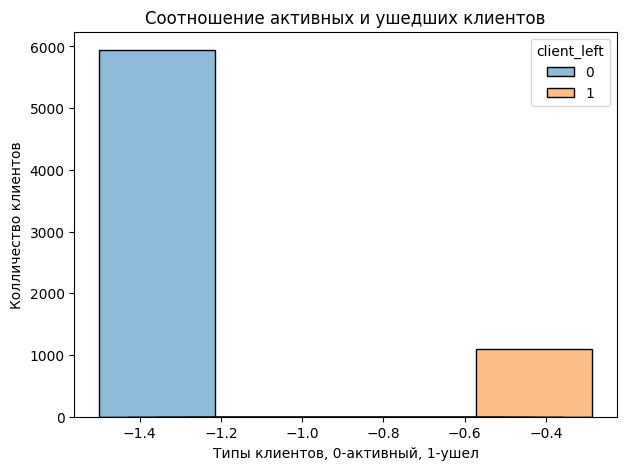

In [60]:
plt.figure(figsize=(7, 5))
sns.histplot(data=df_total, x='client_left', hue='client_left', shrink=4)
plt.title('Соотношение активных и ушедших клиентов')
plt.xlabel('Типы клиентов, 0-активный, 1-ушел')
plt.ylabel('Колличество клиентов')
plt.show()

---

---

**Промежуточный вывод:**

**Видим что активных клиентов в 6 раз больше чем тех кто ушел.**

**Видим по графику, что есть дисбаланс классов, при этом целевая метрика у нас это AUC-ROC, которая не чувствительна к дисбалансу классов. Применять методы для борьбы с дисбалансом классов в дальнейшем не будем.**

---

---

### Исследование признаков

---

---

**Признак `type`**

**Соотношение типов платежей за услуги у активных клиентов и ушедших:**

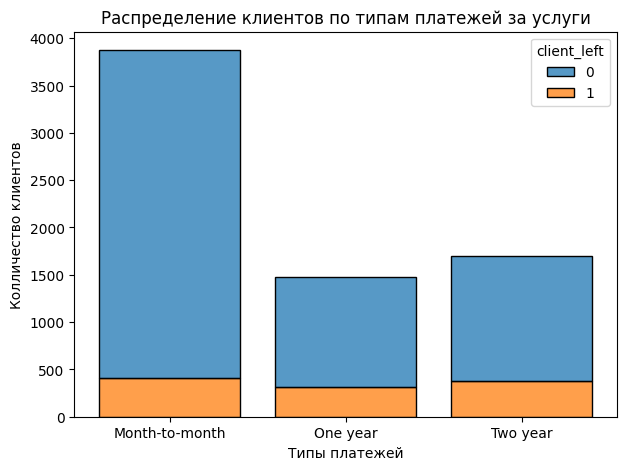

In [61]:
plt.figure(figsize=(7, 5))
sns.histplot(data=df_total, x='type', hue='client_left', multiple='stack', shrink=.8)
plt.title('Распределение клиентов по типам платежей за услуги')
plt.xlabel('Типы платежей')
plt.ylabel('Колличество клиентов')
plt.show()

---

---

**Промежуточный вывод:**

**Видим что большинство активных клиентов предпочитает оплачивать услуги помесячно. Также видим что активных клиентов, которые оплачивают услуги сразу за год или за 2 года меньше примерно в 2.5 раза.**

**Среди ушедших клиентов равномерное распределение по типам платежей.**

**В целом можно сказать, что основная масса клиентов предпочитает платить помесячно.**

---

---

**Признак `monthly_charges`**

**Посмотрим на распределение клиентов по ежемесячным тратам, активных клиентов и ушедших:**

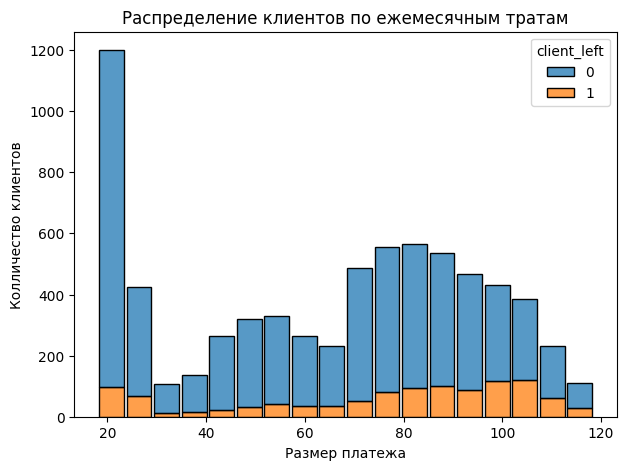

In [62]:
plt.figure(figsize=(7, 5))
sns.histplot(data=df_total, x='monthly_charges', hue='client_left', multiple='stack', shrink=0.9)
plt.title('Распределение клиентов по ежемесячным тратам')
plt.xlabel('Размер платежа')
plt.ylabel('Колличество клиентов')
plt.show()

**Промежуточный вывод:**

**Среди активных клиентов выделяется большое количество с минимальными тратами в месяц. У оставшейся части клиентов распределение по платежам близко к нормальному.**

**У ушедших клиентов тоже выделяется часть клиентов с минимальными платежами в месяц, при этом большое колличество имели платеж 80 - 110, делаем вывод что у них были дополнительные услуги, и/или большой расход какого-либо вида трафика по тарифу. То есть предполагаем, что клиент был настроен не на базовый тариф и минимальным функционалом, а на расширенный и с дополнительными услугами. Предполагаем, что такие клиенты ценны и нужны компании.**

---

---

**Признак `total_charges`**

**Посмотрим на распределение клиентов по общим тратам на услуги, активных клиентов и ушедших:**

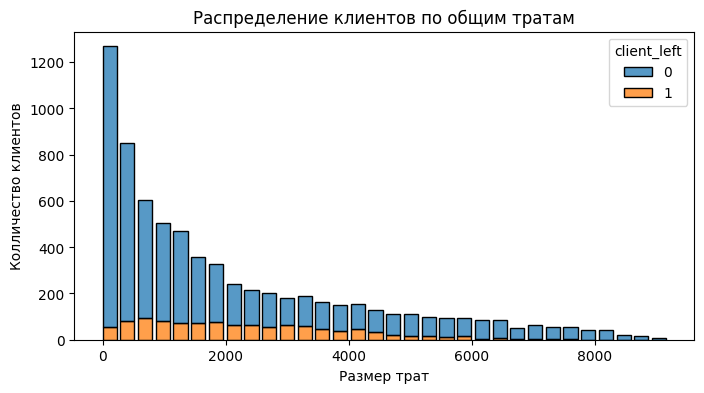

In [63]:
plt.figure(figsize=(8,4))
sns.histplot(data=df_total, x='total_charges', hue='client_left', multiple='stack', shrink=.8)
plt.title('Распределение клиентов по общим тратам')
plt.xlabel('Размер трат')
plt.ylabel('Колличество клиентов')
plt.show()

**Промежуточный вывод:**

**На графике видим, что клиентов, которые ушли, не так много как активных, но они в сумме потратили довольно крупные суммы денег.**

**Видим, что активные клиенты, в большинстве своем, суммарно тратят не так много.**

---

---

**Признак `activity_days`**

**Посмотрим на распределение клиентов по колличеству активных дней пользования услугами, активных клиентов и ушедших:**

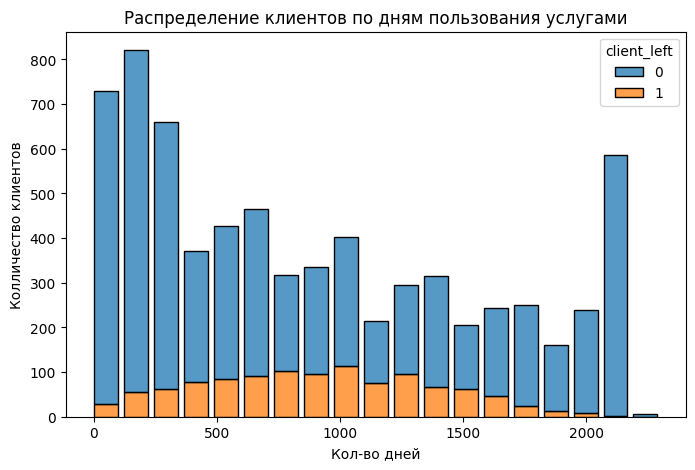

In [64]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df_total, x='activity_days', hue='client_left', multiple='stack', shrink=.8)
plt.title('Распределение клиентов по дням пользования услугами')
plt.xlabel('Кол-во дней')
plt.ylabel('Колличество клиентов')
plt.show()

**Промежуточный вывод:**

**Видим на графике, что ушедшие клиенты минимально пользовались услугами примерно от месяца, предполагаем, что это мог бы быть пробный бесплатный период по акции.**

**Также видим что в среднем, те кто ушли, пользовались услугами довольно продолжительное время, около 900 дней.**

**Из активных клиентов, выделим тех, кто подключился в последние 1.5 года, предполагаем, что была проведена рекламная компания/серия акция и скидок для подключившихся.**

---

---

---

**Признак `paperless_billing`**

**Посмотрим предпочитают ли клиенты, активные и ушедшие, электронные платежные документы:**

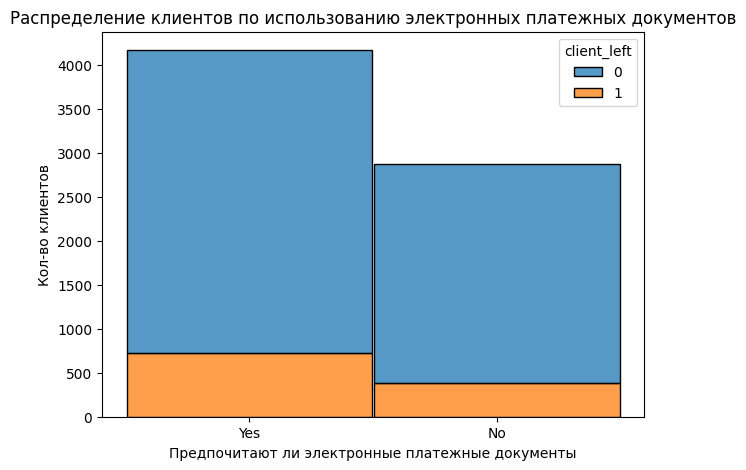

In [65]:
plt.figure(figsize=(7, 5))
sns.histplot(data=df_total, x='paperless_billing', hue='client_left', multiple='stack', shrink=0.99)
plt.title('Распределение клиентов по использованию электронных платежных документов')
plt.xlabel('Предпочитают ли электронные платежные документы')
plt.ylabel('Кол-во клиентов')
plt.show()

**По графику видим, что активные клиенты предпочитают оба варианта, с небольшим перевесом за электронный платеж.**

**Среди ушедших клиентов, в 2 раза больше тех, кто предпочитал электронные платежи.**

---

---

**Признак `payment_method`**

**Посмотрим какой метод оплаты предпочитают клиенты, активные и ушедшие:**

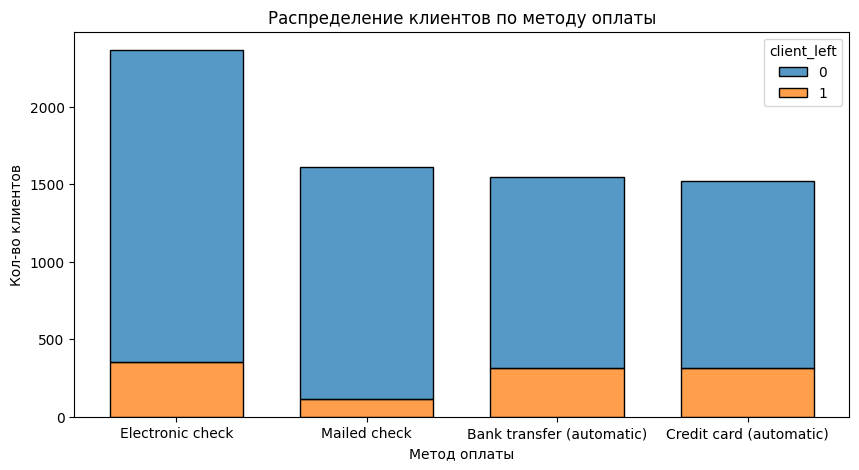

In [66]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df_total, x='payment_method', hue='client_left', multiple='stack', shrink=0.7)
plt.title('Распределение клиентов по методу оплаты')
plt.xlabel('Метод оплаты')
plt.ylabel('Кол-во клиентов')
plt.show()

**Видим, что, среди активных клиентов с небольшим перевесом преобладает электронный чек, остальные способы оплаты примерно на одном уровне.**

**Среди ушедших пользователей совсем не популярен почтовый чек, остальные способы используются почти с равной вероятностью.**

---

---

**Признак `gender`**

**Посмотрим на распределение полов клиентов, активных и ушедших:**

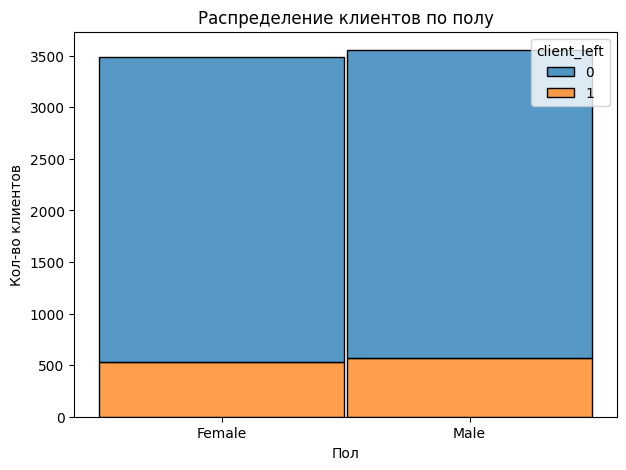

In [67]:
plt.figure(figsize=(7, 5))
sns.histplot(data=df_total, x='gender', hue='client_left', multiple='stack', shrink=0.99)
plt.title('Распределение клиентов по полу')
plt.xlabel('Пол')
plt.ylabel('Кол-во клиентов')
plt.show()

**Видим по графику, что среди активных и ушедших клиентов, разных полов практически поровну.**

---

---

**Признак `senior_citizen`**

**Посмотрим на распределение клиентов по признаку пенсионер или нет, активных и ушедших:**

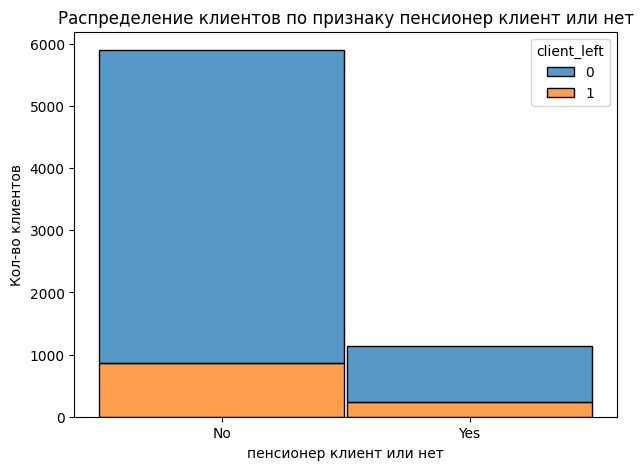

In [68]:
plt.figure(figsize=(7, 5))
sns.histplot(data=df_total, x='senior_citizen', hue='client_left', multiple='stack', shrink=0.99)
plt.title('Распределение клиентов по признаку пенсионер клиент или нет')
plt.xlabel('пенсионер клиент или нет')
plt.ylabel('Кол-во клиентов')
plt.show()

**Видим, что доля пенсионеров среди активных и ушедших клиентов небольшая, при этом среди ушедших доля пенсионеров немного больше.**

---

---

**Признак `partner`**

**Посмотрим на распределение клиентов по признаку наличие супруга, активных и ушедших:**

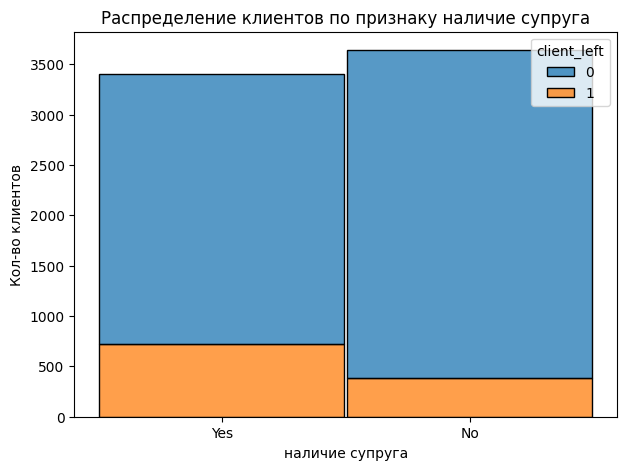

In [69]:
plt.figure(figsize=(7, 5))
sns.histplot(data=df_total, x='partner', hue='client_left', multiple='stack', shrink=0.99)
plt.title('Распределение клиентов по признаку наличие супруга')
plt.xlabel('наличие супруга')
plt.ylabel('Кол-во клиентов')
plt.show()

**Видим, что среди активных клиентов примерно поровну тех, кто с супругом и без.**

**Среди ушедших клиентов, в 2 раза больше тех, кто с супругом.**

---

---

**Признак `dependents`**

**Посмотрим на распределение клиентов по признаку наличие иждивенцев, активных и ушедших клиентов:**

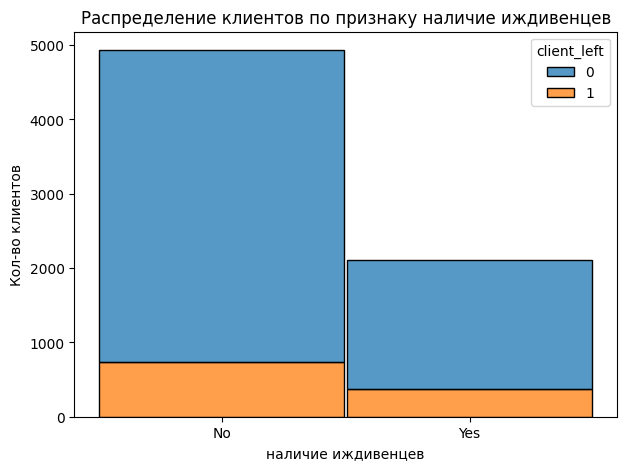

In [70]:
plt.figure(figsize=(7, 5))
sns.histplot(data=df_total, x='dependents', hue='client_left', multiple='stack', shrink=0.99)
plt.title('Распределение клиентов по признаку наличие иждивенцев')
plt.xlabel('наличие иждивенцев')
plt.ylabel('Кол-во клиентов')
plt.show()

**Видим по графику, что в случае активных клиентов и ушедших, тех кто с иждевенцами, больше примерно в 2 раза, чем тех кто без них.**

---

---

**Признак `internet_service`**

**Посмотрим на распределение активных и ушедших клиентов по признаку типа подключения, DSL или Fiber optic:**

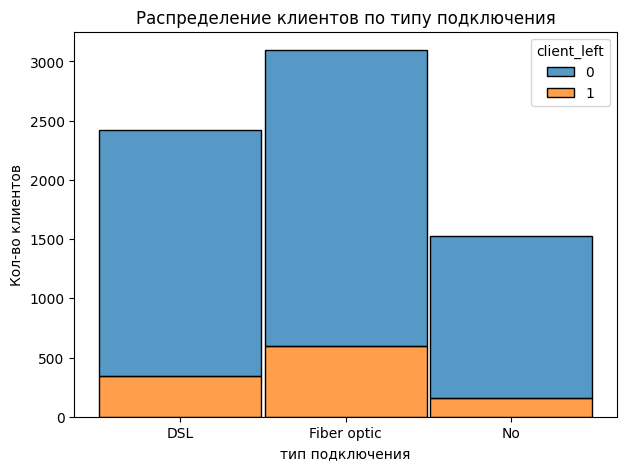

In [71]:
plt.figure(figsize=(7, 5))
sns.histplot(data=df_total, x='internet_service', hue='client_left', multiple='stack', shrink=0.98)
plt.title('Распределение клиентов по типу подключения')
plt.xlabel('тип подключения')
plt.ylabel('Кол-во клиентов')
plt.show()

**По графику видим, что среди ушедших клиентов, в 2 раза преобладает более дорогой тип подключения, по оптическому кабелю, который позволяет получить более высокие скорости, такие тарифы и оборудование стоят дороже.**

**Среди активных клиентов с небольшим перевесом преобладает подключение по оптическому кабелю, в этом случае можно сказать что распрастранены оба типа подключения.**

---

---

**Признак `online_security`**

**Посмотрим на распределение активных и ушедших клиентов по признаку наличия дополнительной услуги интернет защиты:**

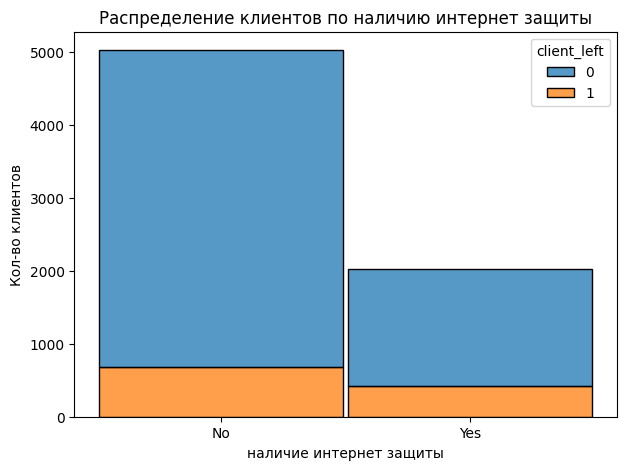

In [72]:
plt.figure(figsize=(7, 5))
sns.histplot(data=df_total, x='online_security', hue='client_left', multiple='stack', shrink=0.98)
plt.title('Распределение клиентов по наличию интернет защиты')
plt.xlabel('наличие интернет защиты')
plt.ylabel('Кол-во клиентов')
plt.show()

**По графику видим, что среди активных клиентов больше половины без интернет защиты, в то время как среди ушедших уже меньше половины. Можно сказать, что ушедшие клменты чаще заботятся о соей безопасности в интернете.**

---

---

**Признак `online_backup`**

**Посмотрим на распределение активных и ушедших клиентов по признаку наличия дополнительной услуги по резервному копированию данных:**

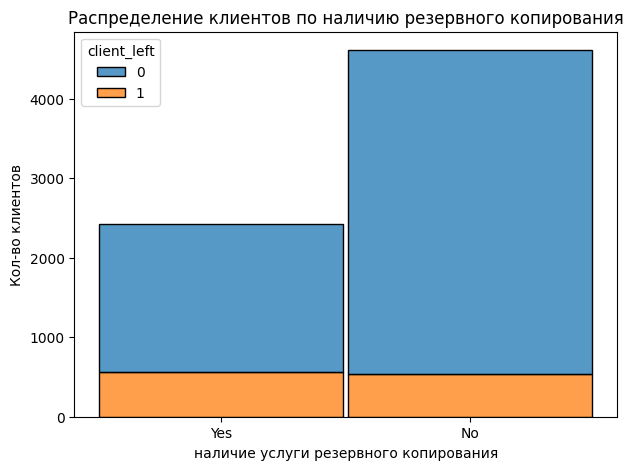

In [73]:
plt.figure(figsize=(7, 5))
sns.histplot(data=df_total, x='online_backup', hue='client_left', multiple='stack', shrink=0.98)
plt.title('Распределение клиентов по наличию резервного копирования')
plt.xlabel('наличие услуги резервного копирования')
plt.ylabel('Кол-во клиентов')
plt.show()

**Среди активных клиентов, в 2 раза больше тех, кто не пользуется услугой резервного копирования. В то время как среди ушедших клиентов это соотношение 50/50. Делаем вывод, что ушедшие клиенты чаще заботились о сохранности своих данных.**

---

---

**Признак `device_protection`**

**Посмотрим на распределение активных и ушедших клиентов по признаку наличия дополнительной услуги по защите устройства:**

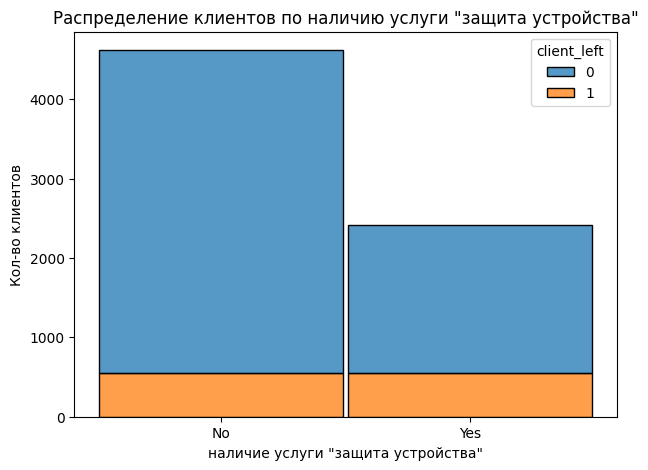

In [74]:
plt.figure(figsize=(7, 5))
sns.histplot(data=df_total, x='device_protection', hue='client_left', multiple='stack', shrink=0.98)
plt.title('Распределение клиентов по наличию услуги "защита устройства"')
plt.xlabel('наличие услуги "защита устройства"')
plt.ylabel('Кол-во клиентов')
plt.show()

**Видим, что среди активных клиентов в 2 раза больше тех, кто этой услугой не пользуется, в то время как среди ушедших клиентов это соотношение около 50/50, предполагаем, что ушедшие клиенты чаще заботятся о защите своих устройств.**

---

---

**Признак `tech_support`**

**Посмотрим на распределение активных и ушедших клиентов по признаку наличия дополнительной услуги по оказанию технической поддержки:**

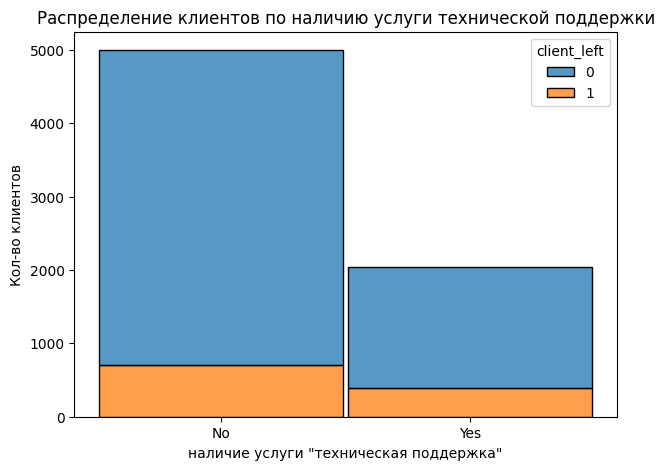

In [75]:
plt.figure(figsize=(7, 5))
sns.histplot(data=df_total, x='tech_support', hue='client_left', multiple='stack', shrink=0.98)
plt.title('Распределение клиентов по наличию услуги технической поддержки')
plt.xlabel('наличие услуги "техническая поддержка"')
plt.ylabel('Кол-во клиентов')
plt.show()

**По графику видим, что активные и ушедшие клиенты, с равной вероятностью пользуются услугой технической поддержки, а именно тех, кто не пользуется в 2 раза больше остальных.**

---

---

**Признак `streaming_tv`**

**Посмотрим на распределение активных и ушедших клиентов по признаку наличия дополнительной услуги стимингового ТВ:**

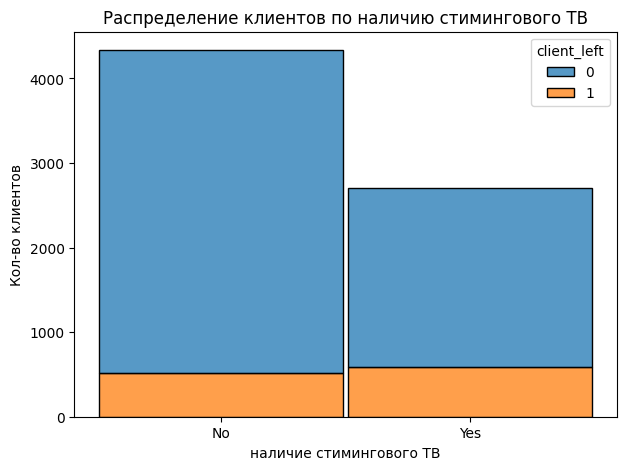

In [76]:
plt.figure(figsize=(7, 5))
sns.histplot(data=df_total, x='streaming_tv', hue='client_left', multiple='stack', shrink=0.98)
plt.title('Распределение клиентов по наличию стимингового ТВ')
plt.xlabel('наличие стимингового ТВ')
plt.ylabel('Кол-во клиентов')
plt.show()

**По графику видим, что среди активных клиентов, тех кто не пользуется стриминговым ТВ, почти в 2 раза больше чем тех кто пользуется.**

**Среди ушедших клиентов, половина пользовалась этой дополнительной услугой.**

---

---

**Признак `streaming_movies`**

**Посмотрим на распределение активных и ушедших клиентов по признаку наличия дополнительной услуги стиминговых фильмов:**

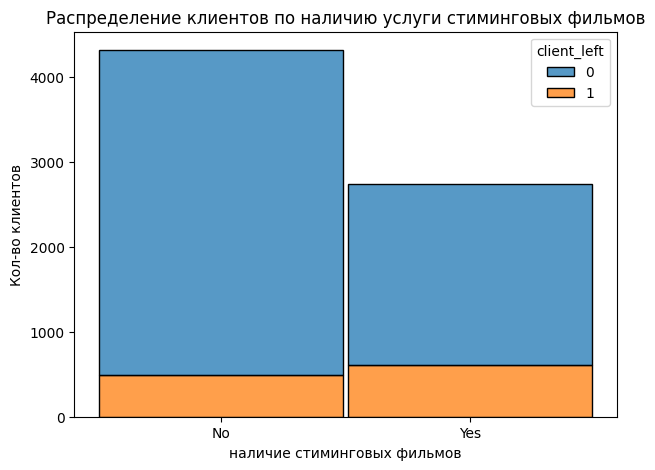

In [77]:
plt.figure(figsize=(7, 5))
sns.histplot(data=df_total, x='streaming_movies', hue='client_left', multiple='stack', shrink=0.98)
plt.title('Распределение клиентов по наличию услуги стиминговых фильмов')
plt.xlabel('наличие стиминговых фильмов')
plt.ylabel('Кол-во клиентов')
plt.show()

**Соотношение схоже с услугой с стримингового ТВ, предполагаем, вероятно эти услуги покупают в пакете.**

**Среди активных также почти в 2 раза больще тех, кто не пользуется.**

**Среди ушедших, соотношение близко к 50/50.**

---

---

**Признак `multiple_lines`**

**Посмотрим на распределение активных и ушедших клиентов по признаку наличия услуги по нескольким параллельным линиям:**

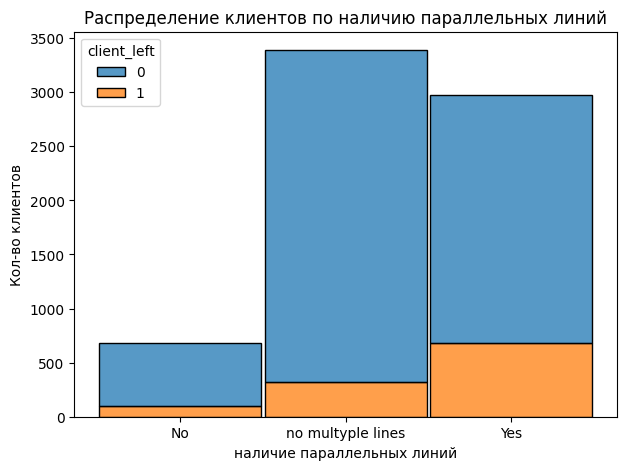

In [78]:
plt.figure(figsize=(7, 5))
sns.histplot(data=df_total, x='multiple_lines', hue='client_left', multiple='stack', shrink=0.98)
plt.title('Распределение клиентов по наличию параллельных линий')
plt.xlabel('наличие параллельных линий')
plt.ylabel('Кол-во клиентов')
plt.show()

**Видим, что у многих активных клиентов подключена услуга по параллельным линиям, тех у кого есть услуга примерно 40%.**

**Среди ушедших клиентов, наоборот в 2 раза больше тех кто с услугой параллельные линии.**

**Делаем вывод, что услуга распространена и востребована для всех клиентов, особенно среди тех, кто ушел.**

---

---

**Промежуточный вывод анализа признаков:**

**Выяснили, что в целевой переменной есть дисбаланс классов, 1/7, но нам он не помешает из-за особенностей метрики качества, которую мы стремимся получить.**

**В результате анализа признаков можно сделать общий образ активного и ушедшего клиента:**
- **активный клиент** - платит помесячно, минимальными суммами, в компании уже несколько лет, предпочитает электронный платеж, без иждивенцев, без дополнительных платных услуг.
- **ушедший клиент** - платил крупные суммы, был с компанией больше 3х лет, не любит платить почтовым чеком, с супругом, не пенсионер, без иждивенцев, были подключены по более дорогому оптическому кабелю, с услугами интернет защиты, технической поддержки, подключенными параллельными линиями связи.

---

---

### Анализ признаков на мультиколлиниарность

---

---

**Построим матрицу корреляции, выведем ее с помощью тепловой карты из библиотеки seaborn:**

interval columns not set, guessing: ['client_left', 'monthly_charges', 'total_charges', 'activity_days']


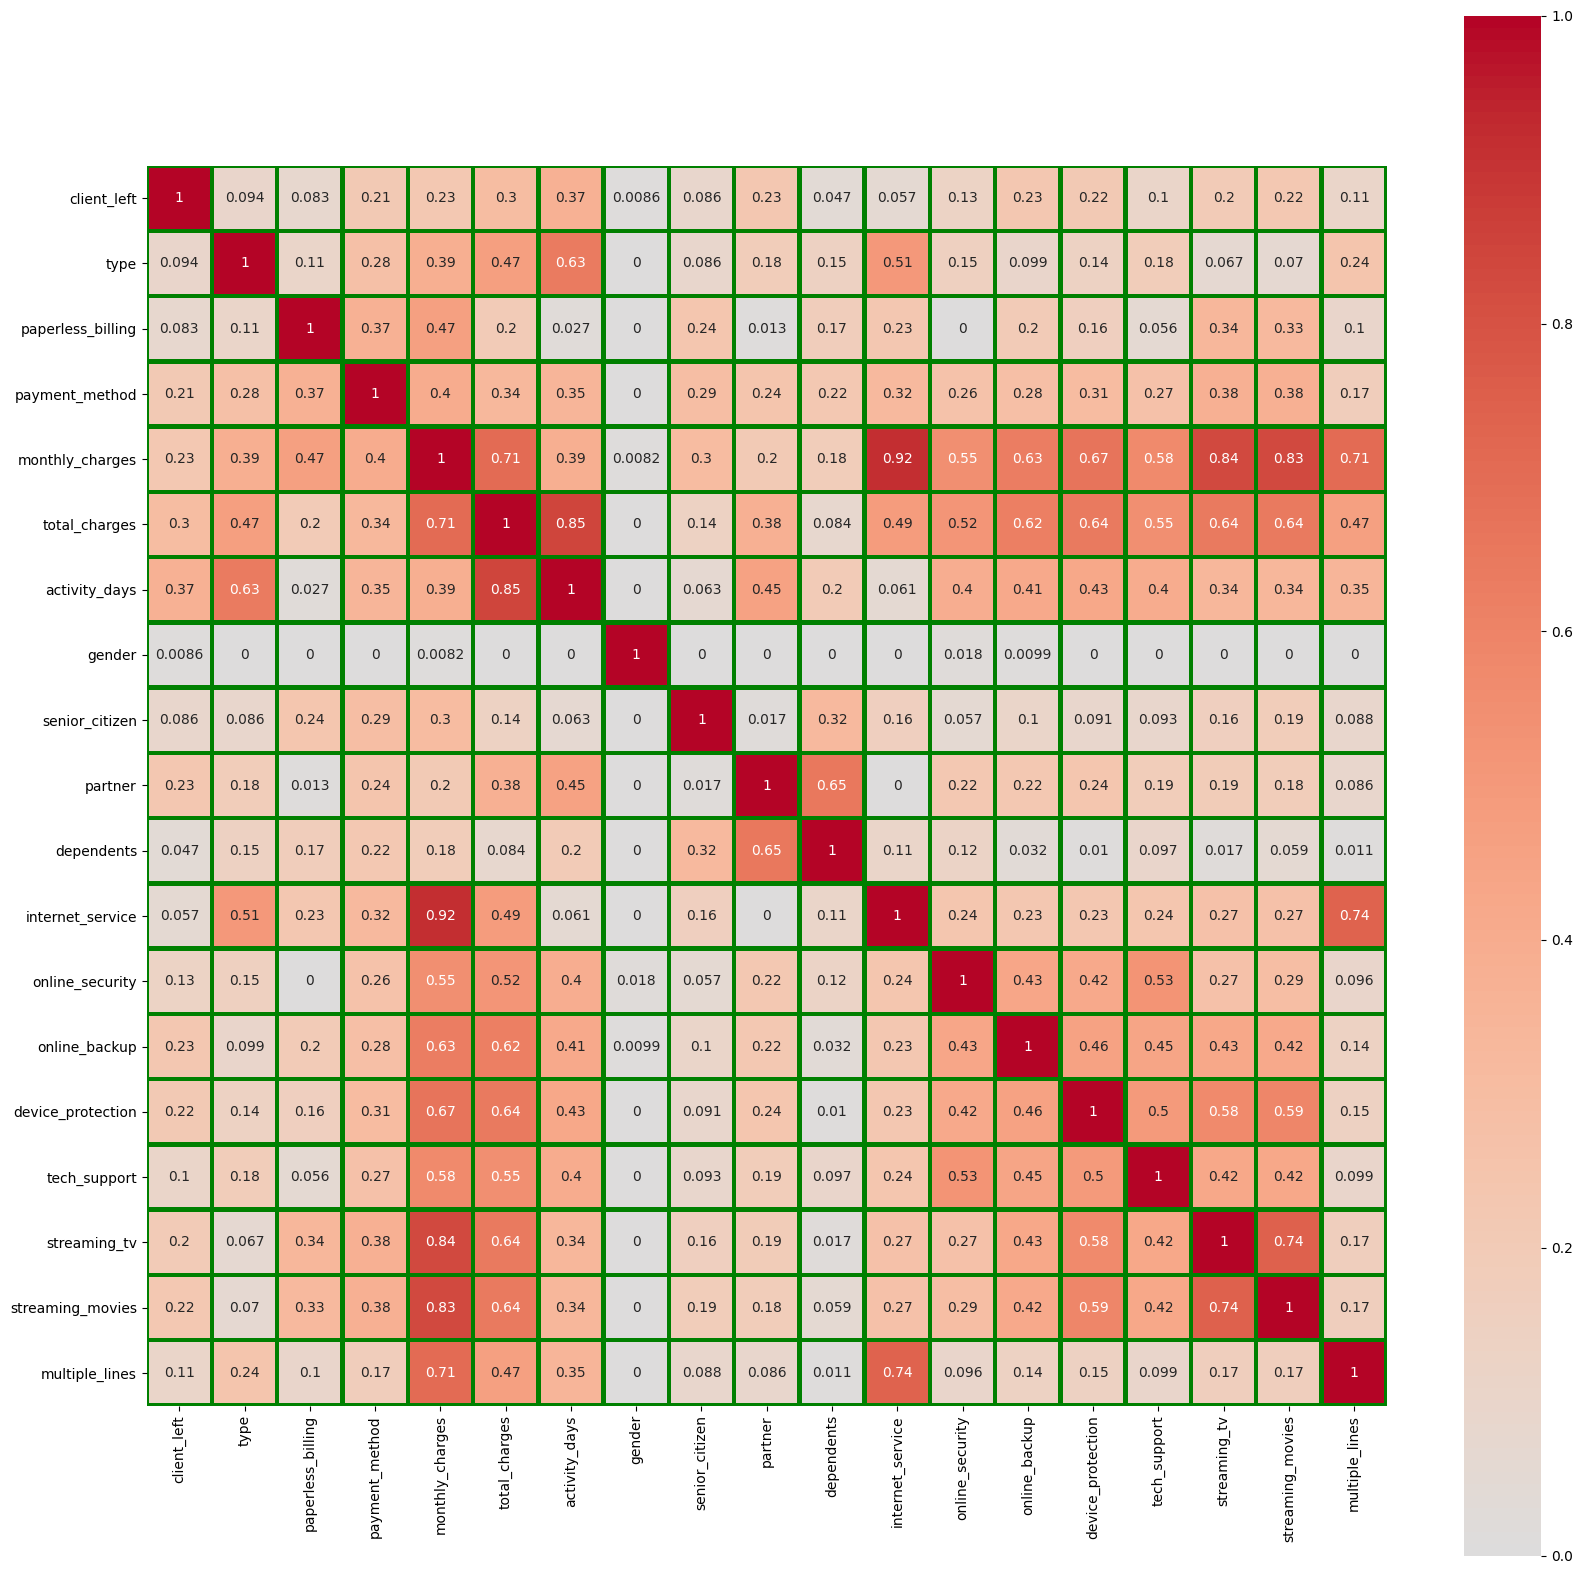

In [79]:
plt.figure(figsize=(20, 20))
sns.heatmap(
    df_total.phik_matrix(),
    annot=True,
    vmin=0,
    vmax=1,
    center=0,
    cmap='coolwarm',
    linewidths=2.5,
    linecolor='green',
    square=True 
)
plt.show()

**Промежуточный вывод:**

**По графику видим, что есть слабая корреляция целевой переменной с колличеством дней, пока клиент пользовался услугами.**

**Видим что есть корреляция наличия дополнительных сервисов и ежемесячных трат, что в целом понятно, чем больше услуг, тем больше ежемесячная плата.**

**Видим также корреляцию между количеством активных дней пользования услугами и общей суммой платежей.**

---

---

### Исследование численных признаков

---

---

**Воспользуемся методом `.pairplot` из библиотеки `seaborn`, построим сетку диаграмм рассеяния, чтобы посмотреть отношения между численными признаками и дополнительно между ними и целевой переменной:**

<Figure size 1200x1200 with 0 Axes>

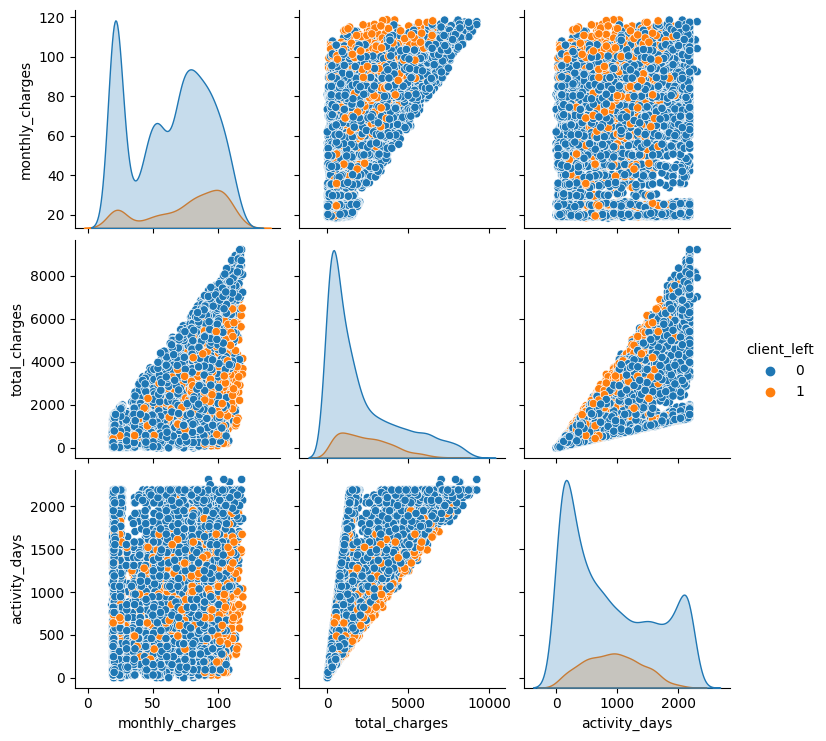

In [80]:
plt.figure(figsize=(12, 12))
sns.pairplot(df_total[['monthly_charges', 'total_charges', 'activity_days', 'client_left']], hue='client_left')
plt.show()

---

**Промежуточный вывод:**

**На графике видна корреляция между total_charges и activity_days, чем больше дней клиент пользовался услугами - тем больше суммарно заплатил. Это верно как для действующих пользователей так и для ушедших.**

**Также видим, что есть корреляция между total_charges и monthly_charges, чем больше месячный платеж тем больше суммарные затраты, как для действующих клиентов, так и для ушедших.**

**Также видим особенность, из тех клиентов, что ушли, большое колличество имели большой ежемесячный платеж, предполагаем что им не понравилось что-то в дополнительных услугах.**

---

---

## ДЕЛЕНИЕ НА ВЫБОРКИ

---

---

**Выделим признаки и целевой признак:**

In [81]:
target = df_total['client_left']
features = df_total.drop('client_left', axis=1)

**Поделим данные на выборки:**

In [82]:
features_train, features_test, target_train, target_test = train_test_split(
features, target, test_size=0.25, random_state=RS)

**Проверим размеры выборок:**

In [83]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(5282, 18)
(1761, 18)
(5282,)
(1761,)


**Сбросим индексы в выборках:**

In [84]:
features_train.reset_index(drop= True , inplace= True)
features_test.reset_index(drop= True , inplace= True)
target_train.reset_index(drop= True , inplace= True)
target_test.reset_index(drop= True , inplace= True)

---

---

## ОБУЧЕНИЕ МОДЕЛЕЙ

---

---

### LogisticRegression

**Перед тем как обучать логистическую регрессию, сделаем кодирование категориальных и масштабирование численных признаков:**

**У нас есть численные признаки в колонках:**
- monthly_charges
- total_charges
- activity_days

**и категориальные признаки в колонках:**
- client_left
- type
- paperless_billing
- payment_method
- gender
- senior_citizen
- partner         
- dependents   
- internet_service
- online_security
- online_backup
- device_protection
- tech_support
- streaming_tv   
- streaming_movies
- multiple_lines

---

---

#### OHE для кодирования категориальный признаков

---

**Создадим список категориальный признаков:**

In [85]:
categorical = [
    'type',
    'paperless_billing',
    'payment_method',
    'gender',
    'senior_citizen',
    'partner',
    'dependents',
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv', 
    'streaming_movies',
    'multiple_lines'
]

**Сделаем копию признаков для кодирования, для конкретно этой модели:**

In [86]:
features_train_log_regr = copy.deepcopy(features_train)
features_test_log_regr = copy.deepcopy(features_test)

**Обучим кодировщик только на обучающей выборке, и применим к обучающей и тестовой:**

In [87]:
enc = OneHotEncoder(drop='first')

enc_df_train = pd.DataFrame(enc.fit_transform(features_train_log_regr[categorical]).toarray())
features_train_log_regr = features_train_log_regr.join(enc_df_train)
features_train_log_regr = features_train_log_regr.drop(categorical,axis=1)

enc_df_test = pd.DataFrame(enc.transform(features_test_log_regr[categorical]).toarray())
features_test_log_regr = features_test_log_regr.join(enc_df_test)
features_test_log_regr = features_test_log_regr.drop(categorical,axis=1)

---

---

#### StandardScaler для масштабирования численный признаков

**Cоздадим список численных признаков:**

In [88]:
numeric = [ 
    'monthly_charges',
    'total_charges',
    'activity_days'
]

---

**Применим StandardScaler к численным признакам:**

In [89]:
scaler_lr = StandardScaler()

scaler_lr.fit(features_train_log_regr[numeric])
features_train_log_regr[numeric] = scaler_lr.transform(features_train_log_regr[numeric])

features_test_log_regr[numeric] = scaler_lr.transform(features_test_log_regr[numeric])

---

**Проверим:**

In [90]:
features_train_log_regr.head(2)

,monthly_charges,total_charges,activity_days,0,1,2,3,4,5,6,...,10,11,12,13,14,15,16,17,18,19
0,0.7083,-0.023713,-0.323653,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,-1.2998,-0.824187,-0.680887,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [91]:
features_test_log_regr.head(2)

,monthly_charges,total_charges,activity_days,0,1,2,3,4,5,6,...,10,11,12,13,14,15,16,17,18,19
0,-0.286615,-0.992164,-1.306047,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1,-1.497454,-0.446538,1.237050,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


---

---

#### Создадим и обучим модель

**Создадим функцию для обучения модели логистической регрессии:**

In [92]:
def log_regr(x_train, y_train):
    model = LogisticRegression(random_state=RS)
    
    parameters = {'solver'  : ['newton-cg', 'lbfgs', 'liblinear']}
    
    model_lr = GridSearchCV(model, parameters, cv=10, scoring='roc_auc', n_jobs=-1)
    model_lr.fit(x_train, y_train)
    
    return model_lr

**Обучим модель:**

In [93]:
%%time
model_lr = log_regr(features_train_log_regr, target_train)

CPU times: user 257 ms, sys: 72.4 ms, total: 329 ms
Wall time: 947 ms


**Посмотри на лучший показатель roc_auc:**

In [94]:
model_lr.best_score_

0.7704174313651636

---

---

### RandomForestClassifier

**Перед обучением сделаем кодирование категориальный признаков и масштабирование численных:**

---

#### OrdinalEncoder для кодирования категориальный признаков

**Сделаем копию признаков для кодирования, для конкретно этой модели:**

In [95]:
features_train_rfc = copy.deepcopy(features_train)
features_test_rfc = copy.deepcopy(features_test)

---

**Применим `OrdinalEncoder`, списки категориальных и численных признаков мы сделали в прошлом пункте:**

In [96]:
or_enc = OrdinalEncoder()
or_enc.fit(features_train_rfc[categorical])

features_train_rfc[categorical] = pd.DataFrame(or_enc.transform(features_train_rfc[categorical]),
                                          columns=features_train_rfc[categorical].columns) 

features_test_rfc[categorical] = pd.DataFrame(or_enc.transform(features_test_rfc[categorical]),
                                          columns=features_test_rfc[categorical].columns) 

---

---

#### StandardScaler для масштабирования численный признаков

**Применим StandardScaler к численным признакам, список численных признаков мы создали ранее:**

In [97]:
scaler_rfc = StandardScaler()

scaler_rfc.fit(features_train_rfc[numeric])
features_train_rfc[numeric] = scaler_rfc.transform(features_train_rfc[numeric])

features_test_rfc[numeric] = scaler_rfc.transform(features_test_rfc[numeric])

---

**Проверим:**

In [98]:
features_train_rfc.head(2)

,type,paperless_billing,payment_method,monthly_charges,total_charges,activity_days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,0.0,1.0,0.0,0.7083,-0.023713,-0.323653,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,3.0,-1.2998,-0.824187,-0.680887,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [99]:
features_test_rfc.head(2)

,type,paperless_billing,payment_method,monthly_charges,total_charges,activity_days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,2.0,0.0,1.0,-0.286615,-0.992164,-1.306047,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
1,2.0,1.0,3.0,-1.497454,-0.446538,1.237050,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


---

---

#### Создадим и обучим модель

**Создадим функцию для обучения модели случайного леса:**

In [100]:
def rfr_rmse(x_train, y_train):
    model = RandomForestClassifier(random_state=RS)
    
    parameters = {'n_estimators': range (10, 51, 10),
                 'max_depth': range (2, 11, 2),
                 'min_samples_split': range (2, 11, 2)}

    model_rfr = GridSearchCV(model, parameters, cv=5, scoring='roc_auc', n_jobs=-1)
    model_rfr.fit(x_train, y_train)
    
    return model_rfr

**Обучим модель случайного леса:**

In [101]:
%%time
model_rfr = rfr_rmse(features_train_rfc, target_train)

CPU times: user 1.59 s, sys: 167 ms, total: 1.76 s
Wall time: 19.2 s


**Посмотри на лучший показатель roc_auc:**

In [102]:
model_rfr.best_score_

0.8341907010401762

---

---

### CatBoostClassifier

---

---

**CatBoost может работать с категориальными признаками без преобразования, будем применять выборки, которые мы получили ранее, без изменений:**

**Создадим функцию для обучения модели CatBoostClassifier:**

In [103]:
def catboost(x_train, y_train):
    cat = CatBoostClassifier(random_state=RS)

    params = {'learning_rate': [0.03, 0.1],
            'depth': [4, 6, 10]}
    
    cat_grid = GridSearchCV(cat, params, scoring='roc_auc', cv=3)
    cat_grid.fit(x_train, y_train, cat_features=categorical, verbose=500)

    return cat_grid

**Обучим модель:**

In [104]:
%%time
cat_model = catboost(features_train, target_train)

0:	learn: 0.6730245	total: 69.3ms	remaining: 1m 9s
500:	learn: 0.2626836	total: 1.53s	remaining: 1.52s
999:	learn: 0.2127294	total: 2.96s	remaining: 0us
0:	learn: 0.6733992	total: 3.05ms	remaining: 3.04s
500:	learn: 0.2746603	total: 1.49s	remaining: 1.48s
999:	learn: 0.2219894	total: 3.02s	remaining: 0us
0:	learn: 0.6742837	total: 5.27ms	remaining: 5.26s
500:	learn: 0.2783748	total: 1.58s	remaining: 1.57s
999:	learn: 0.2299131	total: 3.05s	remaining: 0us
0:	learn: 0.6294639	total: 3.86ms	remaining: 3.86s
500:	learn: 0.1693802	total: 1.53s	remaining: 1.53s
999:	learn: 0.1060061	total: 3.06s	remaining: 0us
0:	learn: 0.6305973	total: 3.12ms	remaining: 3.12s
500:	learn: 0.1732779	total: 1.5s	remaining: 1.5s
999:	learn: 0.1081096	total: 2.99s	remaining: 0us
0:	learn: 0.6332166	total: 3.12ms	remaining: 3.12s
500:	learn: 0.1793755	total: 1.44s	remaining: 1.44s
999:	learn: 0.1173828	total: 2.91s	remaining: 0us
0:	learn: 0.6721800	total: 5.07ms	remaining: 5.07s
500:	learn: 0.2230436	total: 1.88

---

**Посмотри на лучший показатель roc_auc:**

In [105]:
cat_model.best_score_

0.8995534748914732

---

**Посмотрим на лучшие параметры, подобранные в ходе обучения:**

In [106]:
cat_model.best_params_

{'depth': 4, 'learning_rate': 0.1}

---

---

**Промежуточный вывод:**

**В ходе обучения 3-х моделей, по итогам кросс валидации, мы получили метрику roc_auc:**
- LogisticRegression, roc_auc = 0.77
- RandomForestClassifier, roc_auc = 0.83
- CatBoostClassifier, roc_auc = 0.9

**По полученным значениям метрики, делаем вывод, что CatBoostClassifier - лучшая модель по итогам обучения, проведем проверку на тестовой выборке этой модели.**

---

---

## ПРОВЕРКА НА ТЕСТОВОЙ ВЫБОРКЕ

---

---

**Проведем проверку на тестовой выборке модели CatBoostClassifier, которую мы выбрали как лучшую ранее.**

**CatBoostClassifier работает с выборками без кодирования, поэтому будем использовать выборку без изменений:**

---

### Вычислим ROC-AUC

In [107]:
prediction_test = cat_model.predict_proba(features_test)
prediction_one_test = prediction_test[:, 1]
print('ROC-AUC =', roc_auc_score(target_test, prediction_one_test))

ROC-AUC = 0.9194762285009348


---

---

### Построим ROC-кривую

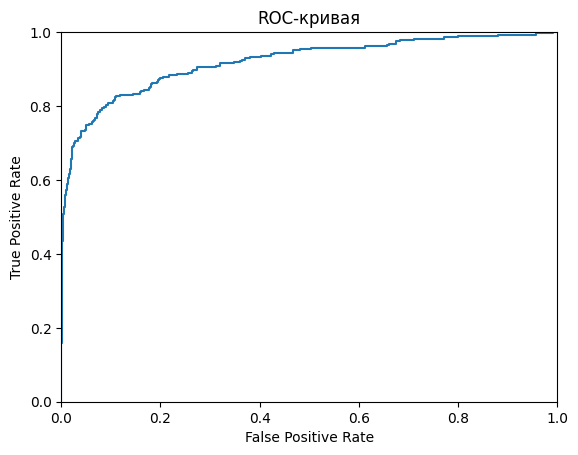

In [108]:
fpr, tpr, thresholds = roc_curve(target_test, prediction_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

---

---

### Построим матрицу ошибок

In [109]:
std_prediction_test = cat_model.predict(features_test)

In [110]:
confusion_matrix(target_test, std_prediction_test)

array([[1449,   29],
       [ 103,  180]])

---

---

**Промежуточный вывод:**

**True Positive (истинно-положительное решение), модель предсказала верно довольно много, 1449 из 1761, мы получили хороший результат.**

**False Positive (ложноположительное решение), 29 случаев когда модель предсказала что клиент уйдет, а на деле он не уйдет, потенциально 29 случаев когда будут предложены скидки, а клиент не собирался уходить, на фоне все всех результатов ошибок получается не много**

**False Negative (ложно-отрицательное решение), модель 103 раза предсказала что клиент не уйдет а он ушел, 103 - небольшое значение, количество ошибок не высокое.**

**True Negative (истинно-отрицательное решение), модель предсказала что клиент уйдет и он ушел в 180-и случаев.**

---

---

### Анализ важности признаков

---

---

**Применим библиотеку shap и построим график важности признаков:**

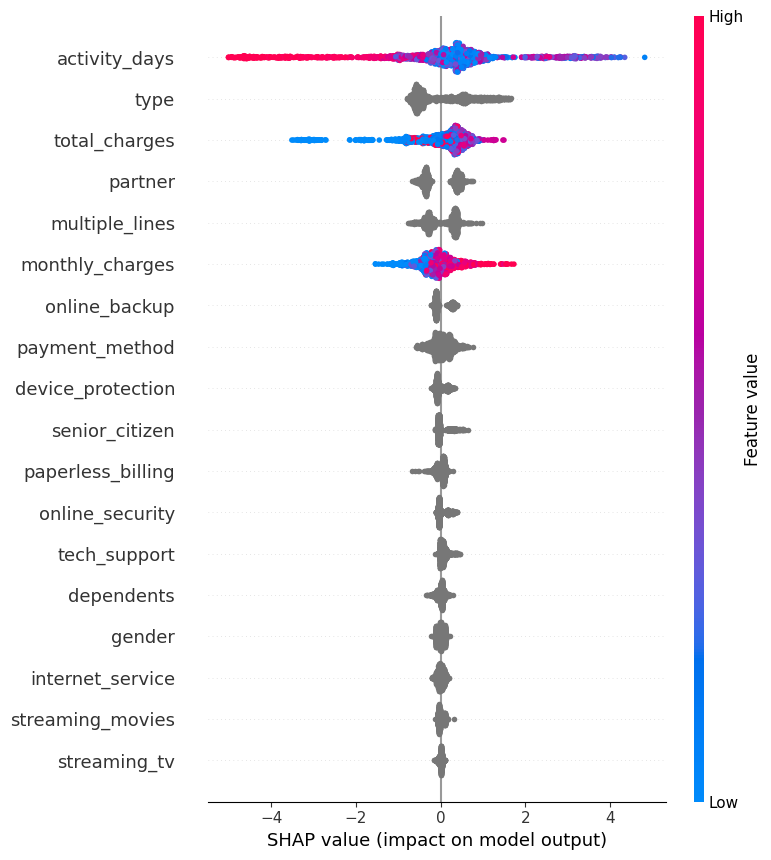

In [111]:
shap_test = shap.TreeExplainer(cat_model.best_estimator_).shap_values(features_test)
shap.summary_plot(shap_test, features_test, auto_size_plot=True)

---

---

**Промежуточный вывод**

**По графику важности признаков видим, что:**
- **важнейший** признак, влияющий на уход клиента - `длительность пользования услугами компании`, предполагаем, что люди такие клиенты подключились акционному предложению бесплатным начальным периодом
- **второй** по важности признак - `величина ежемесячного платежа`, видим, что чем больше платеж тем выше вероятность ухода клиента, предполагаем, что дополнительные платные опции к базовому тарифу могут быть слишком дорогие
- **третий** по важности признак - это `общая сумма всех платежей`, этот признак вытекает из предыдущего, и видим, что чем больше сумма тем больше вероятность, что клиент уйдет.


---

---

## ОБЩИЙ ВЫВОД

---

---

**Мы провели исследование с целью создать модель для прогнозирования ухода клиентов от оператора связи, чтобы в итоге снизить отток клиентов.**

**В ходе исследования, мы проделали такие шаги:**
- провели подготовку данных
- провели анализ
- провели обучение нескольких моделей
- выбрали лучшую модель и провели проверку на тестовых данных
- провели анализ важности признаков

**В ходе исследования мы обнаружили некоторые особенности:**
- основная масса активных клиентов предпочитает платить `минимальный` платеж и платить `помесячно`
- в настоящее время `ушло` около `1/7` всех клиентов
- ушедшие клиенты, в равном степени использовали `все типы платежей` (месяц/год/2года)
- ушедшие клиенты в среднем `платили по 80-110 у. е. в месяц`, предполагаем, что клиент был настроено на `расширенный тариф` с дополнительными платными опциями, и `что-то не понравилось`, предполагаем что это ценные клиенты для компании, рекомендуется обратить внимание на дополнительные платные опции
- ушедшие клиенты пользовались услугами `от месяца`, предполагаем, что это мог бы быть пробный бесплатный период по акции
- ушедшие клиенты в среднем пользовались услугами довольно `продолжительное` время, около `900` дней
- из активных клиентов, выделим тех, кто подключился `в последние 1.5 года`, предполагаем, что рекламная компания/серия акция и скидок для подключившихся были эффективными

**В результате анализа признаков можно сделать общий образ активного и ушедшего клиента:**
- **активный клиент** - платит помесячно, минимальными суммами, в компании уже несколько лет, предпочитает электронный платеж, без иждивенцев, без дополнительных платных услуг.
- **ушедший клиент** - платил крупные суммы, был с компанией больше 3х лет, не любит платить почтовым чеком, с супругом, не пенсионер, без иждивенцев, были подключены по более дорогому оптическому кабелю, с услугами интернет защиты, технической поддержки подключенными параллельными линиями связи.

**Выяснили, что важнейшие признаки, которые влияют на уход клиентов - это:**
- длительность пользования услугами компании
- величина ежемесячного платежа
- общая сумма всех платежей

**В ходе исследования мы выяснили, что самую высокую точность показывает модель CatBoostClassifier**

**На тестовых данных удалось достичь высокой метрики качества AUC-ROC = 0.91**

**В итоге, рекомендуется использовать модель `CatBoostClassifier` с параметрами `'depth': 4, 'learning_rate': 0.1`**